In [1]:
# Utils: 
import pickle
import string
import re
from html.parser import HTMLParser
from collections import Counter
import sys
import random 
import os
import shutil
from tqdm import tqdm

In [2]:
pip install -q tensorflow-io

     |████████████████████████████████| 25.4MB 121kB/s 


In [3]:
# Graphical Tools 
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual

#Computing tools 
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Deep learning Tools
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [8]:
num_classes = 10

In [52]:
if 'text_image_dataset' in os.listdir(): # Remove the text_image_dataset directory if it exists to start from scratch
    shutil.rmtree('text_image_dataset')

In [53]:
for k in range(num_classes):
  os.makedirs(f"text_image_dataset/train/{k}")
  os.makedirs(f"text_image_dataset/test/{k}")

In [11]:
features = pd.read_csv("/content/drive/MyDrive/aicompression/features.csv")
fonts = pd.read_csv("/content/drive/MyDrive/aicompression/fonts.csv", names = ['classes','fonts'], header=0)

In [12]:
fonts

,classes,fonts
0,0,Acme-Regular.ttf
1,1,Baloo-Regular.ttf
2,2,CaviarDreams.ttf
3,3,luckiestguy.ttf
4,4,Niconne-Regular.ttf
5,5,ostrich-regular.ttf
6,6,Pacifico.ttf
7,7,TYPEWR__.TTF
8,8,Walkway_Black.ttf
9,9,Windsong.ttf


In [13]:
features.head()

,Unnamed: 0,name,font,size,color
0,0,img_2,ostrich-regular.ttf,44,"(243, 250, 223)"
1,1,img_3,Walkway_Black.ttf,44,"(245, 254, 245)"
2,2,img_4,Windsong.ttf,57,"(0, 58, 153)"
3,3,img_5,Acme-Regular.ttf,47,"(0, 170, 54)"
4,4,img_6,Windsong.ttf,43,"(253, 243, 246)"


## Create a Dataset for Tensorflow

In [14]:
dataset_dir = "/content/drive/MyDrive/aicompression/image_dataset_v2"
images_names = os.listdir(dataset_dir)

In [54]:
for k in tqdm(range(len(images_names)),desc='moving images to classes'):
  eps = random.random()
  if eps < 0.8 : #80% of total dataset for training
    ft = features[features.name == images_names[k][:-4]]
    if len(ft) > 0:
      ft = ft.reset_index().font[0]
      classe = int(fonts[fonts.fonts == ft].reset_index().classes[0])
      shutil.copy(dataset_dir+'/'+images_names[k],f"text_image_dataset/train/{classe}")
  else : 
    ft = features[features.name == images_names[k][:-4]]
    if len(ft) > 0:
      ft = ft.reset_index().font[0]
      classe = int(fonts[fonts.fonts == ft].reset_index().classes[0])
      shutil.copy(dataset_dir+'/'+images_names[k],f"text_image_dataset/test/{classe}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




moving images to classes:  82%|████████▏ | 4633/5632 [04:54<04:59,  3.33it/s]




moving images to classes:  82%|████████▏ | 4634/5632 [04:54<05:03,  3.29it/s]




moving images to classes:  82%|████████▏ | 4635/5632 [04:54<04:52,  3.41it/s]




moving images to classes:  82%|████████▏ | 4636/5632 [04:55<04:37,  3.59it/s]




moving images to classes:  82%|████████▏ | 4637/5632 [04:55<04:38,  3.57it/s]




moving images to classes:  82%|████████▏ | 4638/5632 [04:55<04:38,  3.57it/s]




moving images to classes:  82%|████████▏ | 4639/5632 [04:55<04:43,  3.51it/s]




moving images to classes:  82%|████████▏ | 4640/5632 [04:56<04:36,  3.59it/s]




moving images to classes:  82%|████████▏ | 4641/5632 [04:56<04:40,  3.54it/s]




moving images to classes:  82%|████████▏ | 4642/5632 [04:56<04:35,  3.60it/s]




moving images to classes:  82%|████████▏ | 4643/5632 [04:57<04:40,  3.52it/s]




moving images to

## Load Dataset

In [114]:
batch_size = 64
img_height = 224
img_width = 224
data_dir_train = "text_image_dataset/train/"
data_dir_test = "text_image_dataset/test/"

In [115]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  #color_mode = 'grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4467 files belonging to 10 classes.
Using 3574 files for training.


In [117]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  #color_mode = 'grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4467 files belonging to 10 classes.
Using 893 files for validation.


In [118]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  #color_mode = 'grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 10 classes.


In [59]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [119]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [125]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax")
])

In [126]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [122]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)       

In [123]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

In [127]:
epochs=500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/500
56/56 [==============================] - 4s 60ms/step - loss: 2.8787 - accuracy: 0.1493 - val_loss: 1.6927 - val_accuracy: 0.4412
Epoch 2/500
56/56 [==============================] - 3s 56ms/step - loss: 1.5410 - accuracy: 0.4424 - val_loss: 1.0747 - val_accuracy: 0.5957
Epoch 3/500
56/56 [==============================] - 3s 56ms/step - loss: 0.9491 - accuracy: 0.6392 - val_loss: 0.8052 - val_accuracy: 0.6842
Epoch 4/500
56/56 [==============================] - 3s 56ms/step - loss: 0.6436 - accuracy: 0.7569 - val_loss: 0.6338 - val_accuracy: 0.7380
Epoch 5/500
56/56 [==============================] - 3s 56ms/step - loss: 0.3956 - accuracy: 0.8533 - val_loss: 0.7106 - val_accuracy: 0.7256
Epoch 6/500
56/56 [==============================] - 3s 57ms/step - loss: 0.3087 - accuracy: 0.8841 - val_loss: 0.6890 - val_accuracy: 0.7368
Epoch 7/500
56/56 [==============================] - 3s 57ms/step - loss: 0.2709 - accuracy: 0.9017 - val_loss: 0.7513 - val_accuracy: 0.7234
Epoch 

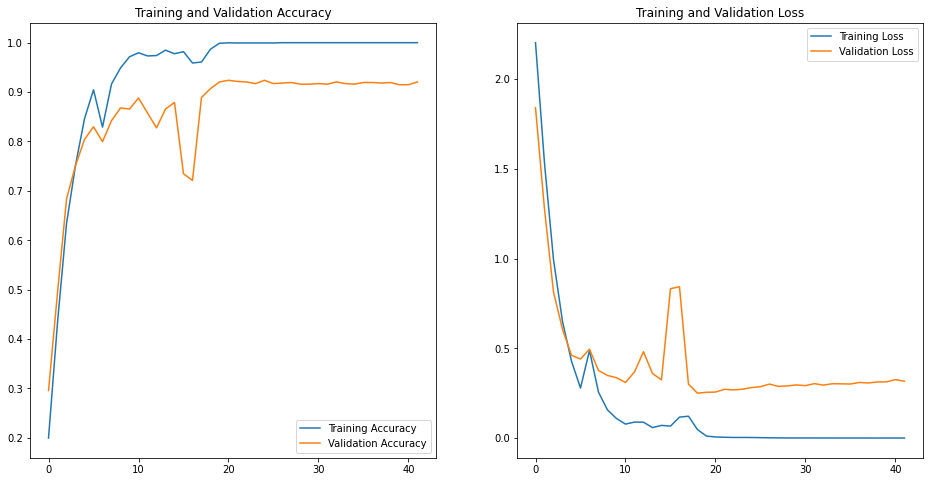

<Figure size 432x288 with 0 Axes>

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_training_loss_acc.eps', format='eps')

In [71]:
def predict(model, dataset): 
    prediction = model.predict(dataset).tolist()
    predicted_labels = [pred.index(max(pred)) for pred in prediction]
    true_labels = []
    for data, label in dataset.as_numpy_iterator(): 
      true_labels.extend(label)
    accscore_labels = accuracy_score(true_labels,predicted_labels) 
    f1score_labels = f1_score(true_labels,predicted_labels,average='macro') # average = 'macro' mean that we average the means of the F1 scores over each label regardless of the population of each label
    print("The accuracy score for each label is :", accscore_labels)
    print("The unweighted mean of the F1 score for each label is :", f1score_labels)
    return predicted_labels,true_labels

In [72]:
predicted_labels,true_labels = predict(model,test_ds)

The accuracy score for each label is : 0.9022491349480969
The unweighted mean of the F1 score for each label is : 0.9005260325450763


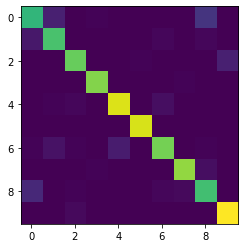

In [73]:
conf_labels = confusion_matrix(true_labels, predicted_labels)
plt.imshow(conf_labels)
plt.savefig('conf_matrix_model.eps', format='eps')

In [74]:
conf_labels

array([[ 84,  11,   0,   1,   0,   0,   0,   0,  19,   0],
       [  8,  91,   0,   0,   0,   0,   2,   0,   2,   0],
       [  0,   0,  98,   0,   0,   1,   0,   0,   0,  11],
       [  0,   0,   0, 104,   0,   0,   0,   1,   0,   0],
       [  0,   1,   2,   0, 121,   0,   5,   0,   0,   0],
       [  0,   0,   0,   0,   0, 120,   0,   0,   0,   0],
       [  1,   6,   1,   0,  10,   0, 101,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0, 107,   5,   0],
       [ 15,   0,   1,   0,   0,   0,   2,   3,  89,   0],
       [  0,   0,   3,   0,   0,   0,   0,   0,   0, 128]])

## Transfer learning and fine tuning

In [75]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [76]:
base_model.trainable = False

In [77]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [78]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [79]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [80]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 10)


In [81]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [82]:
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [83]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810 

In [85]:
loss0, accuracy0 = model.evaluate(val_ds)

14/14 [==============================] - 3s 117ms/step - loss: 2.5649 - accuracy: 0.1472


In [92]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [87]:
history = model.fit(train_ds,
                    epochs=500,
                    validation_data=val_ds,
                    callbacks = [callback])

Epoch 1/500
56/56 [==============================] - 8s 103ms/step - loss: 2.3308 - accuracy: 0.2079 - val_loss: 2.0146 - val_accuracy: 0.3113
Epoch 2/500
56/56 [==============================] - 5s 93ms/step - loss: 1.9841 - accuracy: 0.3092 - val_loss: 1.7465 - val_accuracy: 0.4188
Epoch 3/500
56/56 [==============================] - 5s 93ms/step - loss: 1.7471 - accuracy: 0.3982 - val_loss: 1.5574 - val_accuracy: 0.4994
Epoch 4/500
56/56 [==============================] - 5s 94ms/step - loss: 1.5703 - accuracy: 0.4717 - val_loss: 1.4166 - val_accuracy: 0.5633
Epoch 5/500
56/56 [==============================] - 5s 94ms/step - loss: 1.4429 - accuracy: 0.5204 - val_loss: 1.3045 - val_accuracy: 0.6069
Epoch 6/500
56/56 [==============================] - 5s 94ms/step - loss: 1.3407 - accuracy: 0.5646 - val_loss: 1.2141 - val_accuracy: 0.6506
Epoch 7/500
56/56 [==============================] - 5s 94ms/step - loss: 1.2554 - accuracy: 0.5890 - val_loss: 1.1376 - val_accuracy: 0.6741
Epoch

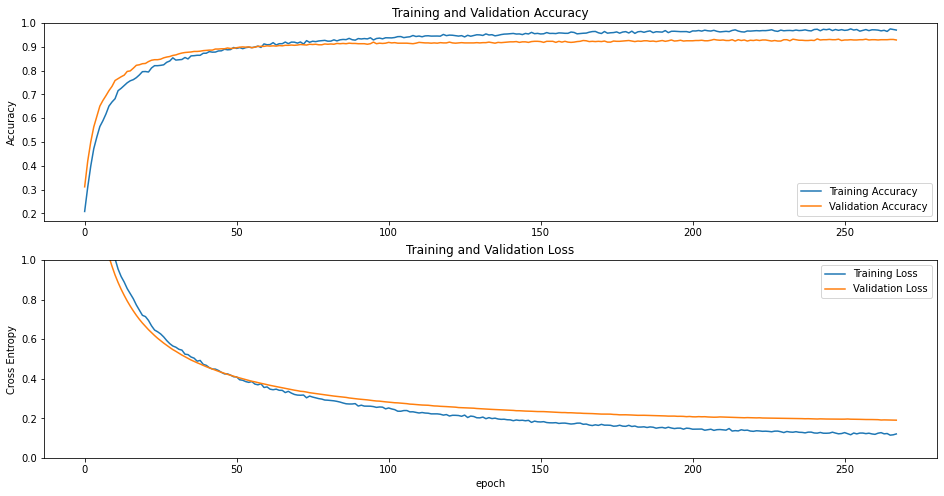

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [89]:
base_model.trainable = True

In [90]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [91]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [93]:
fine_tune_epochs = 268
total_epochs =  500 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                        callbacks = [callback])

Epoch 268/768
56/56 [==============================] - 13s 150ms/step - loss: 0.1672 - accuracy: 0.9417 - val_loss: 0.1761 - val_accuracy: 0.9373
Epoch 269/768
56/56 [==============================] - 7s 130ms/step - loss: 0.1071 - accuracy: 0.9642 - val_loss: 0.2113 - val_accuracy: 0.9138
Epoch 270/768
56/56 [==============================] - 7s 130ms/step - loss: 0.0863 - accuracy: 0.9703 - val_loss: 0.1670 - val_accuracy: 0.9384
Epoch 271/768
56/56 [==============================] - 7s 132ms/step - loss: 0.0699 - accuracy: 0.9782 - val_loss: 0.1727 - val_accuracy: 0.9295
Epoch 272/768
56/56 [==============================] - 7s 132ms/step - loss: 0.0593 - accuracy: 0.9806 - val_loss: 0.1526 - val_accuracy: 0.9440
Epoch 273/768
56/56 [==============================] - 7s 132ms/step - loss: 0.0488 - accuracy: 0.9858 - val_loss: 0.2521 - val_accuracy: 0.9059
Epoch 274/768
56/56 [==============================] - 7s 131ms/step - loss: 0.0506 - accuracy: 0.9829 - val_loss: 0.1714 - val_a

In [94]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [95]:
len(acc)

321

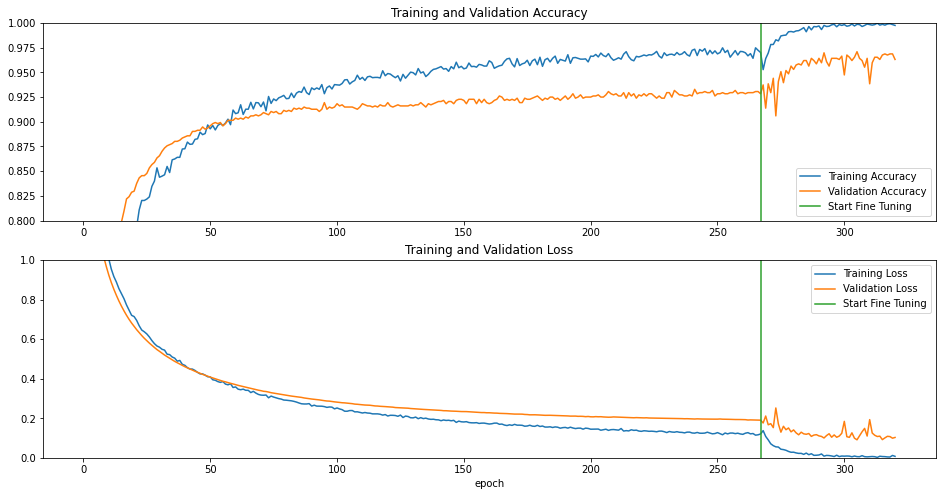

<Figure size 432x288 with 0 Axes>

In [102]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([268-1,268-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([268-1,268-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('training_fine_tuning.eps', format='eps')

In [97]:
predicted_labels,true_labels = predict(model,test_ds)

The accuracy score for each label is : 0.9705882352941176
The unweighted mean of the F1 score for each label is : 0.9704788967969502


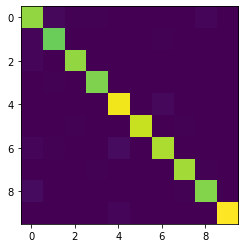

In [99]:
conf_labels = confusion_matrix(true_labels, predicted_labels)
plt.imshow(conf_labels)
plt.savefig('confusion1_fine_tuned.eps', format='eps')

In [100]:
conf_labels

array([[108,   3,   1,   1,   0,   0,   0,   0,   2,   0],
       [  2, 100,   0,   0,   0,   0,   1,   0,   0,   0],
       [  2,   0, 108,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 104,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 126,   0,   3,   0,   0,   0],
       [  0,   0,   1,   0,   0, 118,   0,   1,   0,   0],
       [  2,   1,   0,   0,   4,   0, 113,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0, 111,   1,   0],
       [  4,   0,   0,   0,   0,   0,   0,   1, 105,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0, 129]])